In [1]:
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
import torch
from torch import nn
from typing import Dict, Tuple, Optional
import joblib
import re
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

df_base =df_vcr_c.copy()
obj_cols = df_base.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols) + ["id", "latitud", "longitud"]
df_base = df_base.drop(columns=cols_to_drop)

df_coord =df_vcr_c.copy()
obj_cols = df_coord.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_coord = df_coord.drop(columns=cols_to_drop)

df_vcr_e = pd.read_csv('dataset_vcr_expanded.csv')
df_vcr_e = df_vcr_e[df_vcr_e['monto'] < 56000].copy()
df_vcr_e['log_monto']=np.log(df_vcr_e['monto'])

df_vcr =df_vcr_e.copy()
obj_cols = df_vcr.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_vcr = df_vcr.drop(columns=cols_to_drop)

# Configuración imputacion Dataset VCR
# Dimensiones (1..12) 
DIMS_MAP = {
    1: "count_pois",
    2: "mean_distance",
    3: "min_distance",
    4: "max_distance",
    5: "median_distance",
    6: "std_distance",
    7: "mean_inverse_distance",
    8: "max_inverse_distance",
    9: "sum_inverse_distance",
    10: "ratio_within_near_radius",
    11: "ratio_within_mid_radius",
    12: "ratio_within_far_radius",
}

# Rol por dimensión (para decidir la imputación semántica)
DIM_ROLE = {
    1: "count",                # -> 0
    2: "distance",             # -> R3
    3: "distance",             # -> R3
    4: "distance",             # -> R3
    5: "distance",             # -> R3
    6: "std",                  # -> 0
    7: "inverse",              # -> 0
    8: "inverse",              # -> 0
    9: "inverse",              # -> 0
    10: "ratio",               # -> 0
    11: "ratio",               # -> 0
    12: "ratio",               # -> 0
}

# R3 por tipo de clase
R3_DEFAULT = 2400.0  # clases generales
R3_METRO = 1600.0
R3_BUS = 800.0

# %% Funciones
def _class_and_dim(col: str) -> Optional[Tuple[str, int]]:
    """Extrae (clase, índice de dimensión) de columnas tipo '<clase>_dimXX'."""
    m = re.match(r"^(?P<klass>.+)_dim(?P<idx>\d{1,2})$", col)
    if not m:
        return None
    return m.group("klass"), int(m.group("idx"))


def _r3_for_class(klass: str) -> float:
    k = klass.lower()
    if "metro" in k:
        return R3_METRO
    if "bus" in k:
        return R3_BUS
    return R3_DEFAULT


def impute_vcr_semantic(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa VCR por semántica de ausencia: distancias=R3, inversas/ratios=0, count=0, std=0.
    Además agrega flags `has_<clase>` indicando presencia de POIs por clase.
    """
    out = df.copy()

    # Agrupar columnas por clase
    groups: Dict[str, Dict[int, str]] = {}
    vcr_cols = []
    for c in out.columns:
        parsed = _class_and_dim(c)
        if parsed is None:
            continue
        klass, idx = parsed
        groups.setdefault(klass, {})[idx] = c
        vcr_cols.append(c)

    if not groups:
        # Nada que imputar
        return out

    # Flags de presencia por clase (antes de imputar)
    for klass, dim_map in groups.items():
        cols = list(dim_map.values())
        has_series = out[cols].notna().any(axis=1).astype("int64")
        out[f"has_{klass}"] = has_series  # por qué: distingue ausencia real vs lejanía

    # Imputación por clase/dim
    n_total_nans = int(out[vcr_cols].isna().sum().sum())
    for klass, dim_map in groups.items():
        r3 = _r3_for_class(klass)
        for idx, col in dim_map.items():
            role = DIM_ROLE.get(idx)
            if role == "distance":
                fill_value = r3
            elif role in {"inverse", "ratio", "std", "count"}:
                fill_value = 0.0
            else:
                # Si hay una dimensión desconocida, ser conservador con 0.0
                fill_value = 0.0
            out[col] = out[col].fillna(fill_value)

    n_after_nans = int(out[vcr_cols].isna().sum().sum())
    print(f"Imputación VCR completada. NaNs antes: {n_total_nans:,d} -> después: {n_after_nans:,d}")

    return out

df_vcr_imp = impute_vcr_semantic(df_vcr)


Imputación VCR completada. NaNs antes: 246,228 -> después: 0


### XGBoost Base

In [4]:
# Configuración
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2 # Porcion del set train
# Split
DF = df_base
X = DF.drop(columns=["monto", "log_monto"]).copy()
y = DF["log_monto"].values

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=RANDOM_STATE
    )
print(f"Shapes -> train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

Shapes -> train: (16134, 21), val: (4034, 21), test: (5043, 21)


In [5]:
VERSION_TAG_XGB = "v1" 
BASE_XGB = "models_XGB"

with open(os.path.join(BASE_XGB, f"feature_names_XGB_{VERSION_TAG_XGB}.json"), "r") as f:
    feat_xgb = json.load(f)

model_xgb = xgb.XGBRegressor()
model_xgb.load_model(os.path.join(BASE_XGB, f"XGB_model_{VERSION_TAG_XGB}.json"))

In [6]:
y_pred_test_log  = model_xgb.predict(X_test)
# ---- Residuos en log (test) ----
residuals_log_test = y_test - y_pred_test_log

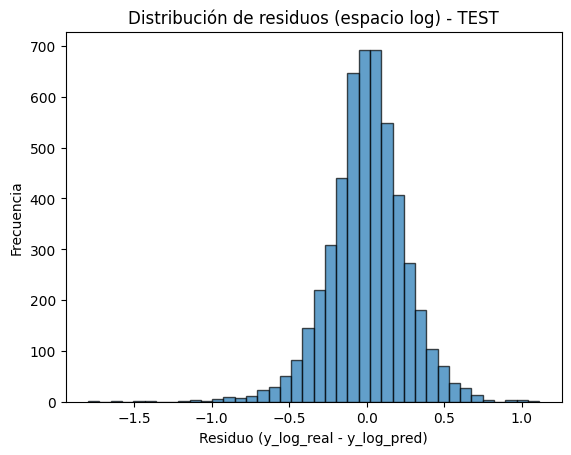

In [7]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

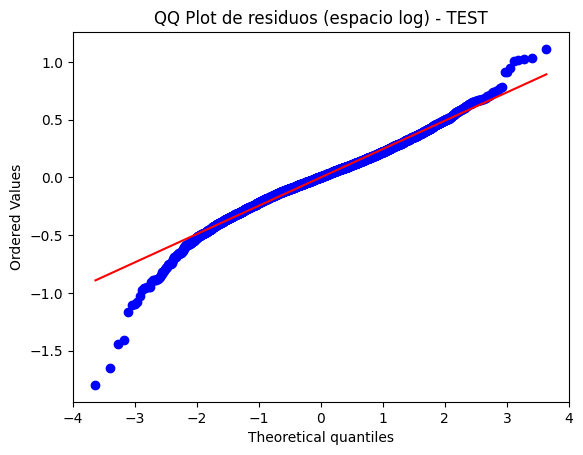

In [12]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

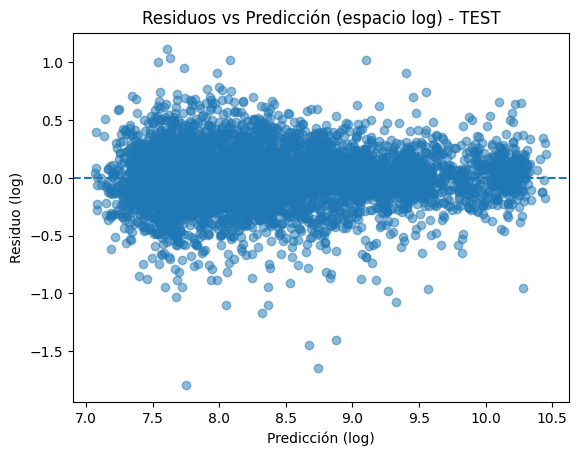

In [13]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

In [14]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 25.913131
LM-Test p-value: 0.000000
F-Statistic: 26.036642
F-Test p-value: 0.000000


### XGBoost Coord

In [15]:
VERSION_TAG_XGB = "v2" 
BASE_XGB = "models_XGB"

# === Cargar artefactos ===
with open(os.path.join(BASE_XGB, f"feature_names_XGB_{VERSION_TAG_XGB}.json"), "r") as f:
    feat_xgb = json.load(f)

model_xgb = xgb.XGBRegressor()
model_xgb.load_model(os.path.join(BASE_XGB, f"XGB_model_{VERSION_TAG_XGB}.json"))

In [17]:
# Configuración
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2 # Porcion del set train
# Split
DF = df_coord
X = DF.drop(columns=["monto", "log_monto"]).copy()
y = DF["log_monto"].values

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=RANDOM_STATE
    )
print(f"Shapes -> train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

Shapes -> train: (16134, 23), val: (4034, 23), test: (5043, 23)


In [18]:
y_pred_test_log  = model_xgb.predict(X_test)
# ---- Residuos en log (test) ----
residuals_log_test = y_test - y_pred_test_log

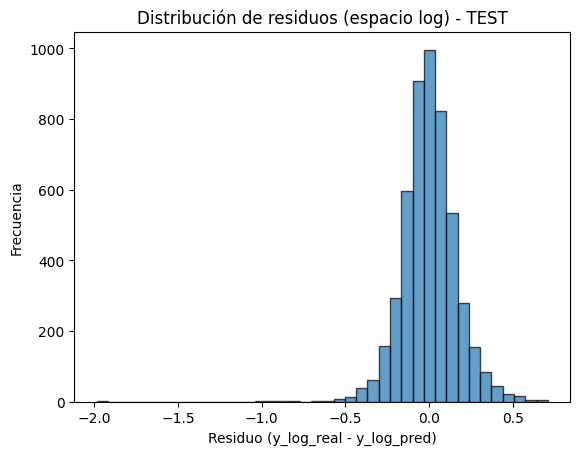

In [19]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

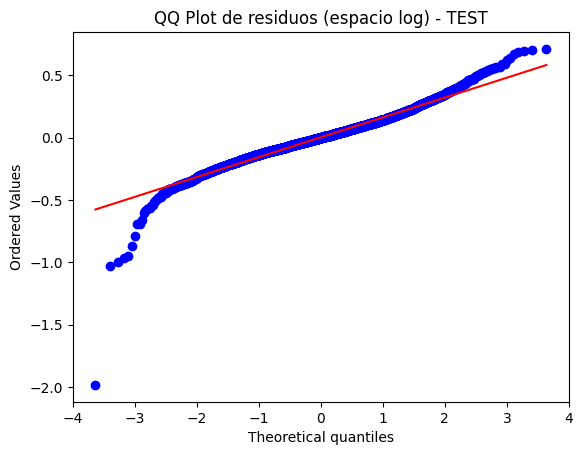

In [20]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

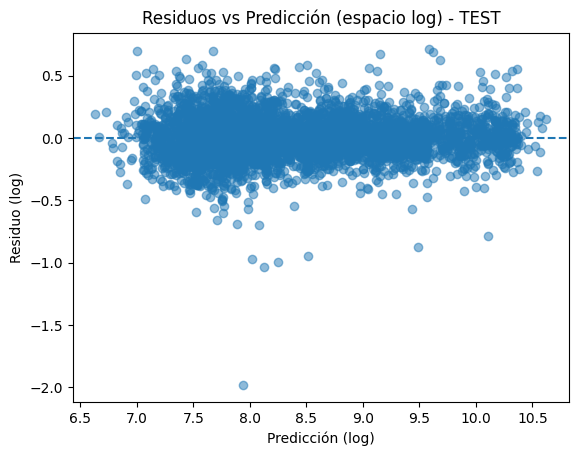

In [21]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

In [22]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 16.729288
LM-Test p-value: 0.000043
F-Statistic: 16.778312
F-Test p-value: 0.000043


### XGBoost VCR

In [23]:
VERSION_TAG_XGB = "v3" 
BASE_XGB = "models_XGB"

# === Cargar artefactos ===
with open(os.path.join(BASE_XGB, f"feature_names_XGB_{VERSION_TAG_XGB}.json"), "r") as f:
    feat_xgb = json.load(f)

model_xgb = xgb.XGBRegressor()
model_xgb.load_model(os.path.join(BASE_XGB, f"XGB_model_{VERSION_TAG_XGB}.json"))

In [24]:
# Configuración
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2 # Porcion del set train
# Split
DF = df_vcr_imp
X = DF.drop(columns=["monto", "log_monto"]).copy()
y = DF["log_monto"].values

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=RANDOM_STATE
    )
print(f"Shapes -> train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

Shapes -> train: (16134, 192), val: (4034, 192), test: (5043, 192)


In [25]:
y_pred_test_log  = model_xgb.predict(X_test)
# ---- Residuos en log (test) ----
residuals_log_test = y_test - y_pred_test_log

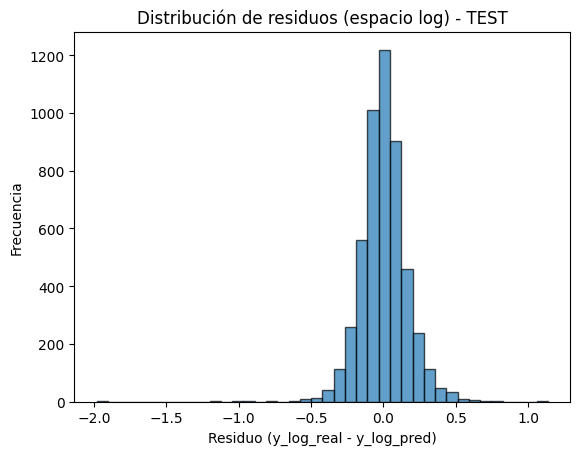

In [26]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

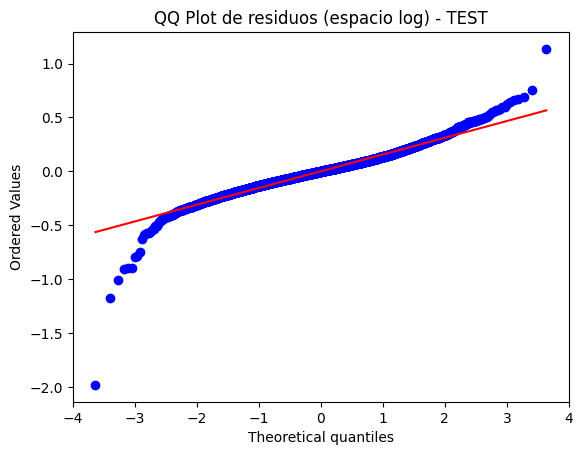

In [27]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

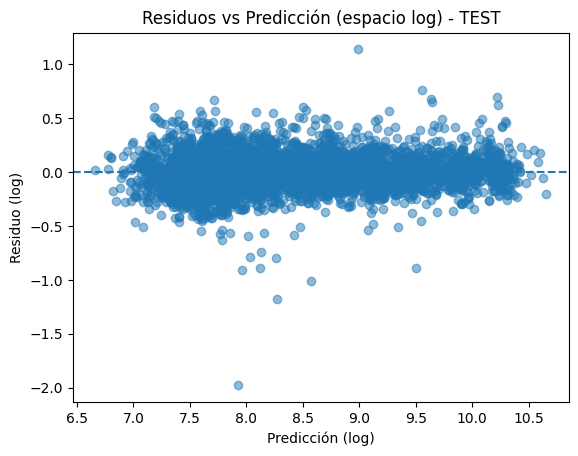

In [28]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

In [29]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 11.005636
LM-Test p-value: 0.000908
F-Statistic: 11.025333
F-Test p-value: 0.000905


### FTT  Base

In [26]:
class NumericTokenizer(nn.Module):
    # Mapea features numéricas a tokens: token_i = x_i * W_i + b_i. W_i es un vector de 128 pesos.
    # Cada fearture deja de ser un numero y se convierte en un vector de 128 dimensiones.
    # Para cada columna i se aprende un peso W_i, que se multiplica por el valor escalar x_i y se 
    # le suma un sesgo b_i para producir el token t_i
    # La funcion toma cada columna y la transforma en un vector en un espacio de dimension D = D_TOKEN = 128
    def __init__(self, n_features: int, d_token: int):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n_features, d_token))
        self.bias = nn.Parameter(torch.zeros(n_features, d_token))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, F) -> (B, F, D)
        return x.unsqueeze(-1) * self.weight + self.bias


class FTTransformer(nn.Module):
    def __init__(self, n_features: int, d_token: int, n_layers: int, n_head: int, ff_mult: int, dropout: float):
        super().__init__()
        self.tokenizer = NumericTokenizer(n_features, d_token)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token)) #Vector aprendido que se añade delante de los tokens de columnas
        enc_layer = nn.TransformerEncoderLayer(
            #n_layers son capas identicas y cada una tiene Multi head self attention pues cada token o columna
            # presta atencino a otras columnas y a si mismo. FeedForward pues tiene un MLP por token con 
            # tamaño d_token * ff_mult. Ademas tiene Dropout mas LayerNorm.
            d_model=d_token,
            nhead=n_head,
            dim_feedforward=d_token * ff_mult,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        # El encoder devuelve (B, 1+F, D)
        
        self.head = nn.Sequential(#Cabeza de regresión. Toma el vector del CLS y lo pasa por una red para 
                                  # producir y (log_monto). (CLS es Classification token, cada uno recibe informacion de 
                                  # todos los demas tokens, de modo que al final del encoder, el CLS contiene un 
                                  # resumen global de toda la entrada)
            nn.LayerNorm(d_token), # Normalización final para estabilidad
            nn.Linear(d_token, d_token),
            nn.GELU(), # Activación
            nn.Dropout(dropout), # Regularización
            nn.Linear(d_token, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)                              # Tensores de 3 dimensiones
        tokens = self.tokenizer(x)                 # (B, F, D)
        cls = self.cls_token.expand(B, -1, -1)     # (B, 1, D), Aqui toma el vector del CLS
        x_tok = torch.cat([cls, tokens], dim=1)    # (B, 1+F, D)
        x_enc = self.encoder(x_tok)                # (B, 1+F, D)
        cls_out = x_enc[:, 0, :]                   # (B, D)
        y = self.head(cls_out).squeeze(-1)         # (B,)
        return y

In [27]:
VERSION_TAG_FTT = "v1" 
BASE_FTT = "models_FTT"

# === Cargar artefactos FTT ===
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))


hp = state["hp"]
model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"], n_layers=hp["n_layers"], n_head=hp["n_head"], ff_mult=hp["ff_mult"], dropout=hp["dropout"],
).to("cuda").eval()
model_ftt.load_state_dict(state["model_state"]) # pesos

<All keys matched successfully>

In [28]:
# --- Cargar artefactos EXACTOS del entrenamiento ---
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))

hp = state["hp"]

# --- Alinear columnas en el mismo orden que feat_ftt ---
X_df = df_base[feat_ftt].copy()         # <— MUY IMPORTANTE
y = df_base["log_monto"].astype(np.float32).values

SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.25   # usa el MISMO que en entrenamiento original

# Splits
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

# --- Usar el MISMO scaler guardado ---
X_train = scaler.transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)


In [29]:
device = torch.device("cuda")

model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"],
    n_layers=hp["n_layers"],
    n_head=hp["n_head"],
    ff_mult=hp["ff_mult"],
    dropout=hp["dropout"],
).to(device).eval()

model_ftt.load_state_dict(state["model_state"])  # <— pesos correctos


<All keys matched successfully>

In [30]:
class NpDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y.astype(np.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx])

batch_size = hp.get("batch_size", 256)

test_dl = DataLoader(NpDataset(X_test, y_test), batch_size=batch_size, shuffle=False, pin_memory=True)

@torch.no_grad()
def predict_with_truth(model, dl, device):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in dl:
        xb = xb.to(device, non_blocking=True)
        out = model(xb).detach().cpu().numpy()
        y_true.append(yb.numpy())
        y_pred.append(out)
    return np.concatenate(y_true), np.concatenate(y_pred)

y_true_log_test, y_pred_test_log = predict_with_truth(model_ftt, test_dl, device)

# Residuos EN LOG correctamente alineados:
residuals_log_test = y_true_log_test - y_pred_test_log

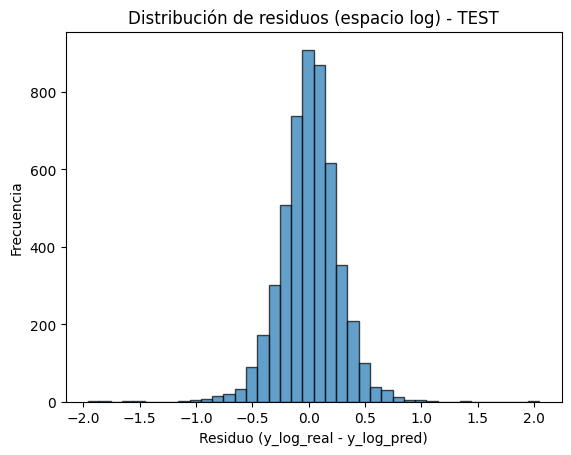

In [31]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

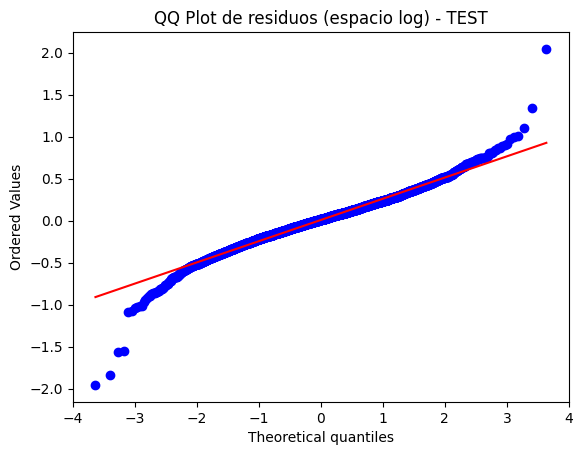

In [32]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

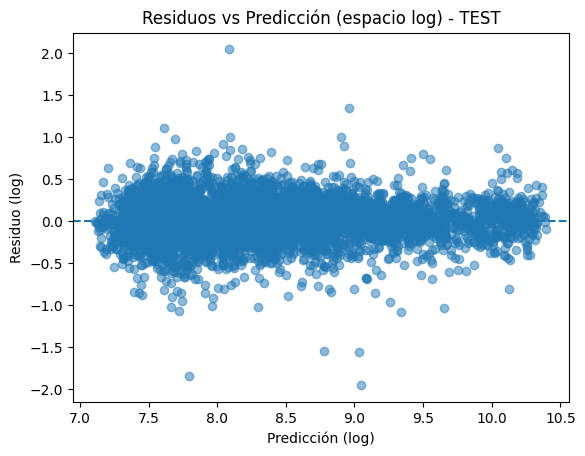

In [33]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

In [34]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 15.160548
LM-Test p-value: 0.000099
F-Statistic: 15.200231
F-Test p-value: 0.000098


### FTT Coord

In [35]:
VERSION_TAG_FTT = "v2" 
BASE_FTT = "models_FTT"

# === Cargar artefactos FTT ===
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))


hp = state["hp"]
model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"], n_layers=hp["n_layers"], n_head=hp["n_head"], ff_mult=hp["ff_mult"], dropout=hp["dropout"],
).to("cuda").eval()
model_ftt.load_state_dict(state["model_state"]) # pesos

<All keys matched successfully>

In [36]:
# --- Cargar artefactos EXACTOS del entrenamiento ---
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))

hp = state["hp"]

# --- Alinear columnas en el mismo orden que feat_ftt ---
X_df = df_coord[feat_ftt].copy()         # <— MUY IMPORTANTE
y = df_base["log_monto"].astype(np.float32).values

SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.25   # usa el MISMO que en entrenamiento original

# Splits
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

# --- Usar el MISMO scaler guardado ---
X_train = scaler.transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)


In [37]:
device = torch.device("cuda")

model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"],
    n_layers=hp["n_layers"],
    n_head=hp["n_head"],
    ff_mult=hp["ff_mult"],
    dropout=hp["dropout"],
).to(device).eval()

model_ftt.load_state_dict(state["model_state"])  # <— pesos correctos


<All keys matched successfully>

In [38]:
class NpDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y.astype(np.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx])

batch_size = hp.get("batch_size", 256)

test_dl = DataLoader(NpDataset(X_test, y_test), batch_size=batch_size, shuffle=False, pin_memory=True)

@torch.no_grad()
def predict_with_truth(model, dl, device):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in dl:
        xb = xb.to(device, non_blocking=True)
        out = model(xb).detach().cpu().numpy()
        y_true.append(yb.numpy())
        y_pred.append(out)
    return np.concatenate(y_true), np.concatenate(y_pred)

y_true_log_test, y_pred_test_log = predict_with_truth(model_ftt, test_dl, device)

# Residuos EN LOG correctamente alineados:
residuals_log_test = y_true_log_test - y_pred_test_log

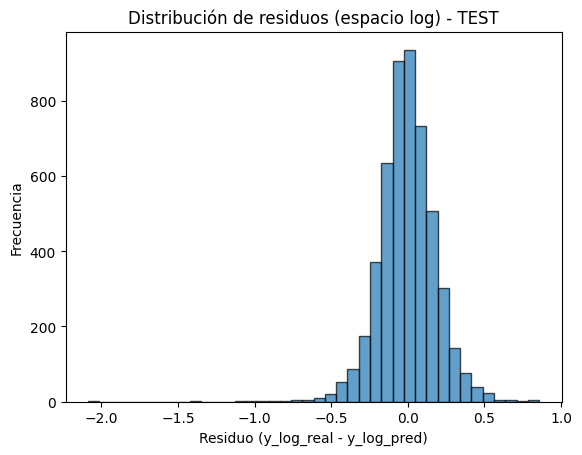

In [39]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

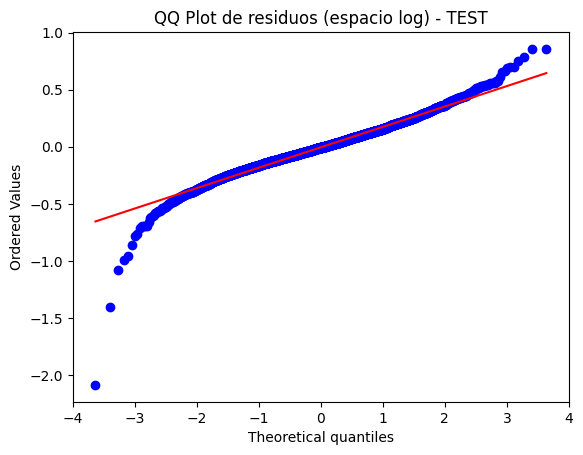

In [40]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

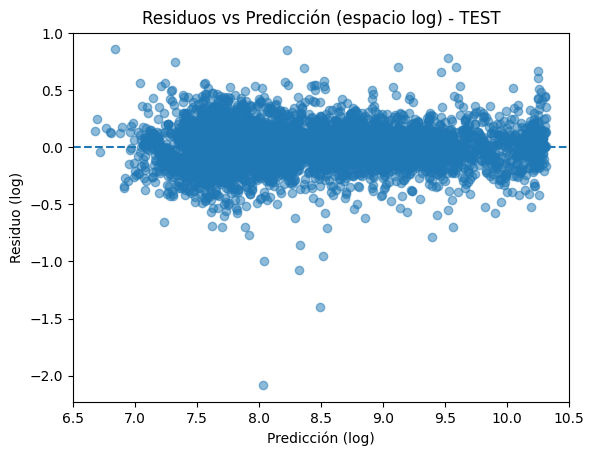

In [41]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

In [42]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 9.076416
LM-Test p-value: 0.002589
F-Statistic: 9.089175
F-Test p-value: 0.002584


### FTT VCR

In [43]:
VERSION_TAG_FTT = "v3" 
BASE_FTT = "models_FTT"

# === Cargar artefactos FTT ===
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))


hp = state["hp"]
model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"], n_layers=hp["n_layers"], n_head=hp["n_head"], ff_mult=hp["ff_mult"], dropout=hp["dropout"],
).to("cuda").eval()
model_ftt.load_state_dict(state["model_state"]) # pesos

<All keys matched successfully>

In [44]:
# --- Cargar artefactos EXACTOS del entrenamiento ---
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))

hp = state["hp"]

# --- Alinear columnas en el mismo orden que feat_ftt ---
X_df = df_vcr_imp[feat_ftt].copy()         # <— MUY IMPORTANTE
y = df_base["log_monto"].astype(np.float32).values

SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.25   # usa el MISMO que en entrenamiento original

# Splits
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

# --- Usar el MISMO scaler guardado ---
X_train = scaler.transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)


In [45]:
device = torch.device("cuda")

model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"],
    n_layers=hp["n_layers"],
    n_head=hp["n_head"],
    ff_mult=hp["ff_mult"],
    dropout=hp["dropout"],
).to(device).eval()

model_ftt.load_state_dict(state["model_state"])  # <— pesos correctos


<All keys matched successfully>

In [46]:
class NpDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y.astype(np.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx])

batch_size = hp.get("batch_size", 256)

test_dl = DataLoader(NpDataset(X_test, y_test), batch_size=batch_size, shuffle=False, pin_memory=True)

@torch.no_grad()
def predict_with_truth(model, dl, device):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in dl:
        xb = xb.to(device, non_blocking=True)
        out = model(xb).detach().cpu().numpy()
        y_true.append(yb.numpy())
        y_pred.append(out)
    return np.concatenate(y_true), np.concatenate(y_pred)

y_true_log_test, y_pred_test_log = predict_with_truth(model_ftt, test_dl, device)

# Residuos EN LOG correctamente alineados:
residuals_log_test = y_true_log_test - y_pred_test_log

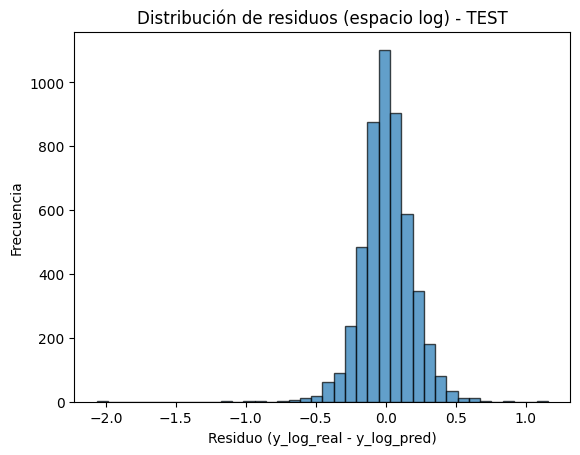

In [47]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

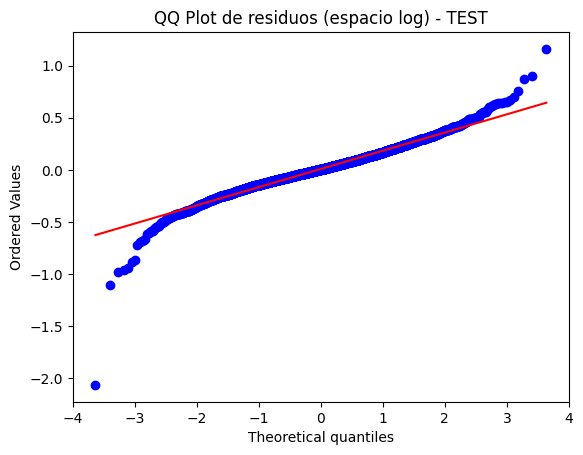

In [48]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

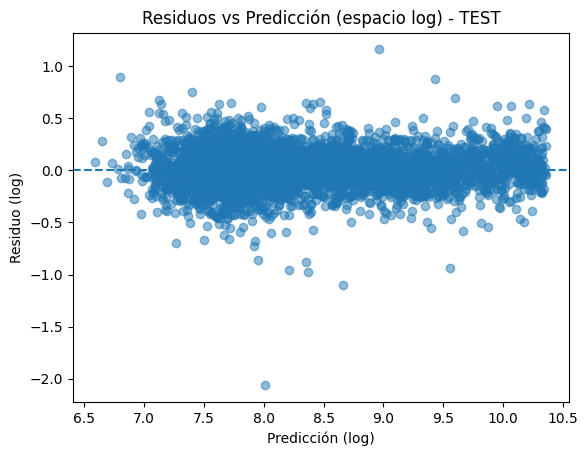

In [49]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

In [50]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 9.198996
LM-Test p-value: 0.002421
F-Statistic: 9.212152
F-Test p-value: 0.002416


### MLP Base

In [10]:
# --- Cargar artefactos y alinear features ---
VERSION_TAG_MLP = "v1"
BASE_MLP = "models"
SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2   

In [11]:
# Orden de columnas EXACTO
with open(os.path.join(BASE_MLP, f"feature_names_mlp_{VERSION_TAG_MLP}.json"), "r") as f:
    feature_names = json.load(f)

X_df = df_base[feature_names].copy()
y = df_base["log_monto"].values.astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

# Scaler guardado (NO reentrenar)
scaler = joblib.load(os.path.join(BASE_MLP, f"scaler_mlp_{VERSION_TAG_MLP}.joblib"))
X_test = scaler.transform(X_test).astype(np.float32)

# --- Cargar modelo ---
model_MLP = keras.models.load_model(os.path.join(BASE_MLP, f"best_model_mlp_{VERSION_TAG_MLP}.keras"))

# --- Predicción y shapes seguros ---
y_pred_test_log = model_MLP.predict(X_test, verbose=0)
y_pred_test_log = np.asarray(y_pred_test_log).reshape(-1)  # (n,) en vez de (n,1)

# Sanity checks de forma
assert y_pred_test_log.ndim == 1 and y_pred_test_log.shape[0] == y_test.shape[0], \
    f"Shapes incompatibles: y_pred={y_pred_test_log.shape}, y_test={y_test.shape}"

# --- Residuos 1D en log (OK) ---
residuals_log_test = y_test - y_pred_test_log
print("Residuos (log): mean={:.6f}, std={:.6f}".format(residuals_log_test.mean(), residuals_log_test.std()))


Residuos (log): mean=0.002372, std=0.258792


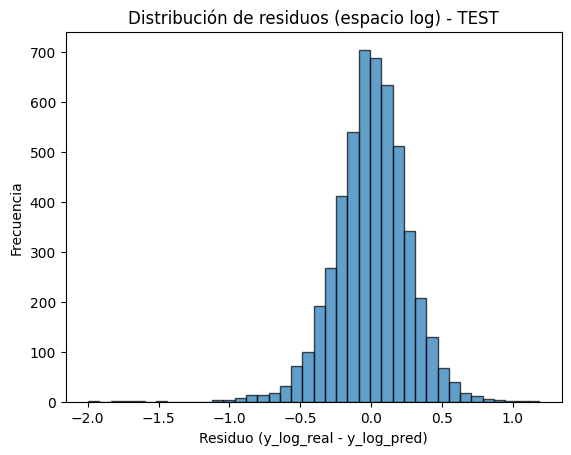

In [12]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

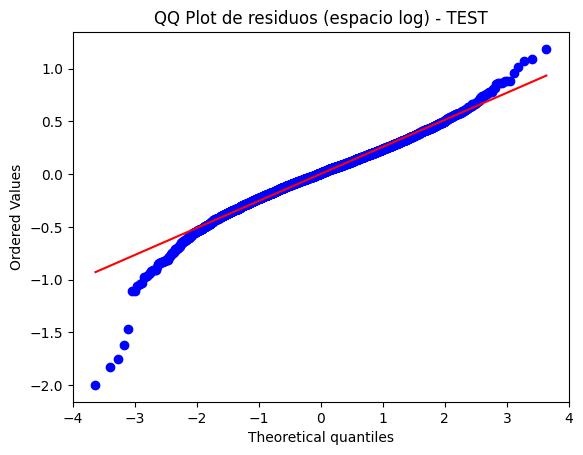

In [13]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

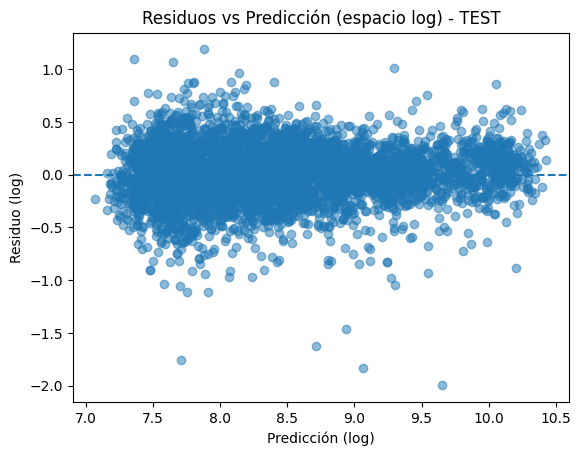

In [14]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

In [15]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 14.664682
LM-Test p-value: 0.000128
F-Statistic: 14.701617
F-Test p-value: 0.000127


### MLP Coord

In [16]:
# --- Cargar artefactos y alinear features ---
VERSION_TAG_MLP = "v2"
BASE_MLP = "models"
SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2   

In [17]:
# Orden de columnas EXACTO
with open(os.path.join(BASE_MLP, f"feature_names_mlp_{VERSION_TAG_MLP}.json"), "r") as f:
    feature_names = json.load(f)

X_df = df_coord[feature_names].copy()
y = df_coord["log_monto"].values.astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

# Scaler guardado (NO reentrenar)
scaler = joblib.load(os.path.join(BASE_MLP, f"scaler_mlp_{VERSION_TAG_MLP}.joblib"))
X_test = scaler.transform(X_test).astype(np.float32)

# --- Cargar modelo ---
model_MLP = keras.models.load_model(os.path.join(BASE_MLP, f"best_model_mlp_{VERSION_TAG_MLP}.keras"))

# --- Predicción y shapes seguros ---
y_pred_test_log = model_MLP.predict(X_test, verbose=0)
y_pred_test_log = np.asarray(y_pred_test_log).reshape(-1)  # (n,) en vez de (n,1)

# Sanity checks de forma
assert y_pred_test_log.ndim == 1 and y_pred_test_log.shape[0] == y_test.shape[0], \
    f"Shapes incompatibles: y_pred={y_pred_test_log.shape}, y_test={y_test.shape}"

# --- Residuos 1D en log (OK) ---
residuals_log_test = y_test - y_pred_test_log
print("Residuos (log): mean={:.6f}, std={:.6f}".format(residuals_log_test.mean(), residuals_log_test.std()))

Residuos (log): mean=0.002127, std=0.183285


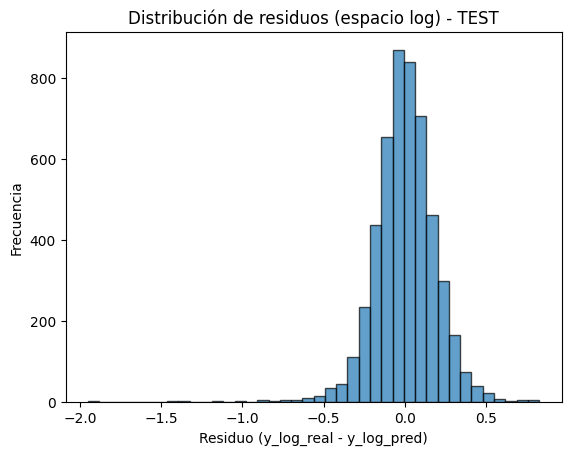

In [18]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

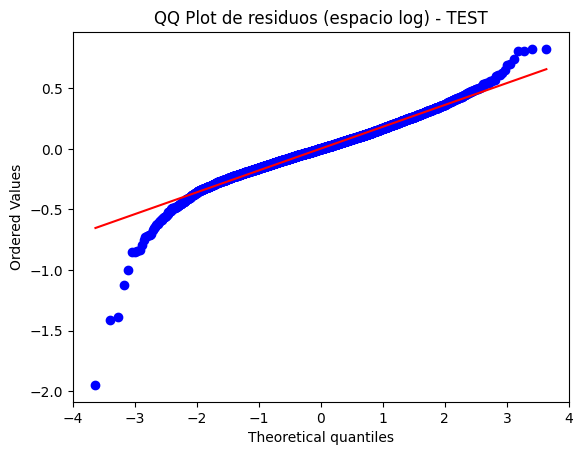

In [19]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

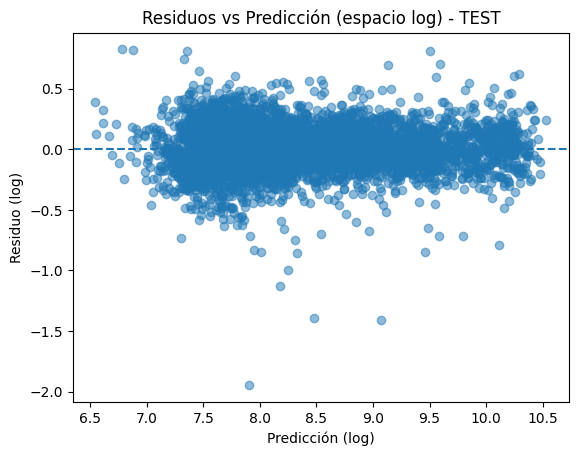

In [20]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

In [21]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 19.321526
LM-Test p-value: 0.000011
F-Statistic: 19.388146
F-Test p-value: 0.000011


### MLP VCR

In [22]:
# --- Cargar artefactos y alinear features ---
VERSION_TAG_MLP = "v3"
BASE_MLP = "models"
SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2   

In [24]:
# Orden de columnas EXACTO
with open(os.path.join(BASE_MLP, f"feature_names_mlp_{VERSION_TAG_MLP}.json"), "r") as f:
    feature_names = json.load(f)

X_df = df_vcr_imp[feature_names].copy()
y = df_vcr_imp["log_monto"].values.astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

# Scaler guardado (NO reentrenar)
scaler = joblib.load(os.path.join(BASE_MLP, f"scaler_mlp_{VERSION_TAG_MLP}.joblib"))
X_test = scaler.transform(X_test).astype(np.float32)

# --- Cargar modelo ---
model_MLP = keras.models.load_model(os.path.join(BASE_MLP, f"best_model_mlp_{VERSION_TAG_MLP}.keras"))

# --- Predicción y shapes seguros ---
y_pred_test_log = model_MLP.predict(X_test, verbose=0)
y_pred_test_log = np.asarray(y_pred_test_log).reshape(-1)  # (n,) en vez de (n,1)

# Sanity checks de forma
assert y_pred_test_log.ndim == 1 and y_pred_test_log.shape[0] == y_test.shape[0], \
    f"Shapes incompatibles: y_pred={y_pred_test_log.shape}, y_test={y_test.shape}"

# --- Residuos 1D en log (OK) ---
residuals_log_test = y_test - y_pred_test_log
print("Residuos (log): mean={:.6f}, std={:.6f}".format(residuals_log_test.mean(), residuals_log_test.std()))

Residuos (log): mean=-0.012321, std=0.179169


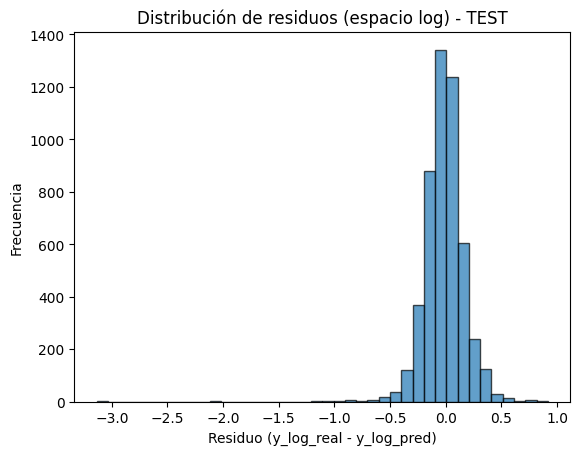

In [25]:
plt.figure()
plt.hist(residuals_log_test, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de residuos (espacio log) - TEST")
plt.xlabel("Residuo (y_log_real - y_log_pred)")
plt.ylabel("Frecuencia")
plt.show()

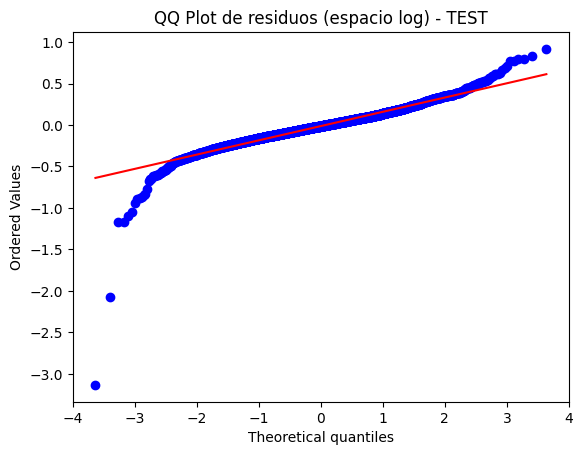

In [26]:
plt.figure()
stats.probplot(residuals_log_test, dist="norm", plot=plt)
plt.title("QQ Plot de residuos (espacio log) - TEST")
plt.show()

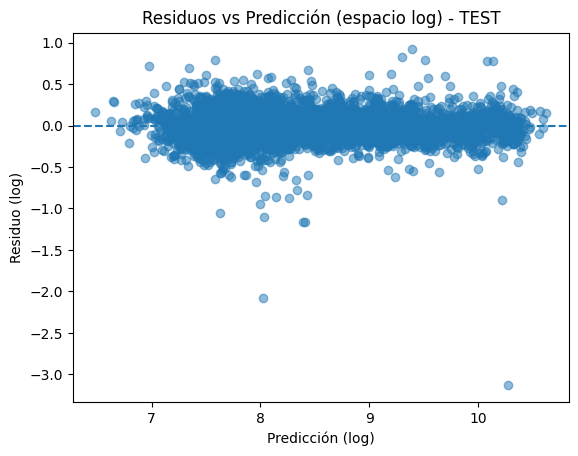

In [27]:
plt.figure()
plt.scatter(y_pred_test_log, residuals_log_test, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción (log)")
plt.ylabel("Residuo (log)")
plt.title("Residuos vs Predicción (espacio log) - TEST")
plt.show()

In [28]:
# BP necesita un modelo OLS de los residuos^2 vs predictores (aquí usamos la predicción como regressor simple)
X_bp = sm.add_constant(y_pred_test_log)  # regresor: predicción en log
bp_test = het_breuschpagan(residuals_log_test, X_bp)

bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.6f}")


LM Statistic: 0.033386
LM-Test p-value: 0.855019
F-Statistic: 0.033373
F-Test p-value: 0.855054
